# Mask R-CNN - Train cell nucleus Dataset


This notebook shows how to train Mask R-CNN implemented on coco on your own dataset. I trained the model to segment cell nucleus objects in an image. You'd need a GPU, because the network backbone is a Resnet101, which would be too slow to train on a CPU.The code is execuatble on google colaboratory GPU.  On google colab you can start to get okay-ish results in a few minutes, and good results in less than an hour.



2020/11/26 This is file is modified by Pingfan Song for use with tensorflow 1.x in Colab. For use with tensorflow 2.x, please take care of various compatiblity issues.

2020/12/18 This is file is modified by Huang Yilin for use with tensorflow 2.x in Colab. The first change in on line 2370 in model_tf2.py, the variable use_multiprocessing is set to 0 to prevent use of multi-processing since tensorflow2.0 is not compatible with multi-processing. The second minor change is in the shapeconfig function. The variable use_mini_mask is set to false since it will result in dimension differences between the mask and the original image. 

2021/4/1 This file is modified by Huang Yilin for use with processing light field image and runnning cell segmentation on pre-processed LF image. 

In [1]:
%tensorflow_version 2.x

In [2]:
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)

2.5.0
2.5.0


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Colab_Notebooks/nucleus_tf2
# !pwd && ls

/content/drive/MyDrive/Colab_Notebooks/nucleus_tf2


In [5]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import pandas as pd

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize

In [6]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../")
print(ROOT_DIR)
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

/content/drive/MyDrive/Colab_Notebooks


In [7]:
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model_tf2 as modellib
from mrcnn.model_tf2 import log

from mrcnn import config
from mrcnn.config import Config
%matplotlib inline 

In [8]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
# if not os.path.exists(COCO_MODEL_PATH):
#     utils.download_trained_weights(COCO_MODEL_PATH)

In [9]:
# Data Path
TRAIN_PATH = os.path.join(ROOT_DIR, "datasets/nucleus/stage1_train/") # 'datasets/nucleus/stage1_train/'
# TEST_PATH = os.path.join(ROOT_DIR, "datasets/nucleus/stage1_test/") # 'stage1_test/'
TEST_PATH = os.path.join(ROOT_DIR, "datasets/nucleus/LF_image_x732_y1756/") # path for LF images

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
# print(test_ids.index('12'))

## Configurations

In [10]:
class ShapesConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides values specific
    to the dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"
    # NAME = "nucleus" # spf

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU. Batch size is (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + nucleus

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 896
    IMAGE_MAX_DIM = 896

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 64, 128, 256)  # anchor side in pixels

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 800

    # set number of epoch
    STEPS_PER_EPOCH = 200

    # set validation steps 
    VALIDATION_STEPS = 50

    # do not use mini-mask, it would result in a broadcast issue 
    # i.e. the size of the mask does not match the size of image # hyl
    USE_MINI_MASK = False # hyl
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  896
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  896
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [896 896   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [11]:
DEVICE = "/gpu:0" # hyl, use of gpu for training can increase the speed

In [12]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [13]:
class ShapesDataset(utils.Dataset):
    
    def load_shapes(self, mode):
        
        # Add classes
        self.add_class("shapes", 1, "nucleus")
        

        if mode == "train":  
            for n, id_ in enumerate(train_ids):
                if n < int(len(train_ids) * 0.9):
                    path = TRAIN_PATH + id_
                    img_path = path + '/images/'
                    self.add_image("shapes", image_id=id_, path=img_path)
              
        if mode == "val":   
            for n, id_ in enumerate(test_ids): # "val" mode should be test database, not train. hyl
                if n >= int(len(test_ids) * 0.9): # same here. hyl
                    path = TEST_PATH + id_ # same here, hyl
                    img_path = path + '/images/'
                    self.add_image("shapes", image_id=id_, path=img_path)      

    def load_image(self, image_id):
        
        info = self.image_info[image_id]
        info = info.get("id")
       
        path = TRAIN_PATH + info
        img = imread(path + '/images/' + info + '.png')[:,:,:3]
        img = resize(img, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
       
        return img

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        
        info = self.image_info[image_id]
        info = info.get("id")
        path = TRAIN_PATH + info
        number_of_masks = len(next(os.walk(path + '/masks/'))[2])
        mask = np.zeros([config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], number_of_masks], dtype=np.uint8)
        iterator = 0
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = resize(mask_, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
            mask[:, :, iterator] = mask_
            iterator += 1
            # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(number_of_masks-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
            
        # Map class names to class IDs.
        class_ids = np.ones((number_of_masks,), dtype=int)
        
        return mask, class_ids.astype(np.int32)
         
       
        

In [14]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes("train")
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes("val")
dataset_val.prepare()

[240]


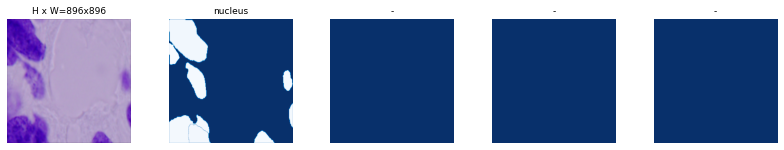

In [15]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 1)
print(image_ids)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [16]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [17]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.

# model.train(dataset_train, dataset_val,
#             learning_rate=config.LEARNING_RATE, 
#             epochs=1, 
#             layers="heads")

Epoch 1/1

 10/200 [>.............................] - ETA: 12:31 - loss: 4.8084 - rpn_class_loss: 0.7304 - rpn_bbox_loss: 1.8862 - mrcnn_class_loss: 0.5416 - mrcnn_bbox_loss: 1.0326 - mrcnn_mask_loss: 0.6176/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)

 200/200 [==============================] - 1857s 9s/step - loss: 1.7989 - rpn_class_loss: 0.1737 - rpn_bbox_loss: 0.8692 - mrcnn_class_loss: 0.1151 - mrcnn_bbox_loss: 0.3555 - mrcnn_mask_loss: 0.2854 - val_loss: 0.9837 - val_rpn_class_loss: 0.2154 - val_rpn_bbox_loss: 0.6110 - val_mrcnn_class_loss: 0.1027 - val_mrcnn_bbox_loss: 0.2500 - val_mrcnn_mask_loss: 0.2279
WARNING:tensorflow:From /tensorflow-1.15.2/python3.6/keras/callbacks/tensorboard_v1.py:343: The name tf.Summary is deprecated. Please use tf.compat.v1.Summary instead.


In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 0. LR=0.0001

Checkpoint Path: /content/drive/MyDrive/Colab_Notebooks/logs/shapes20210127T0244/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub_1:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_cl

200/200 [==============================] - ETA: 0s - batch: 99.5000 - size: 1.0000 - loss: 1.6517 - rpn_class_loss: 0.1658 - rpn_bbox_loss: 0.6822 - mrcnn_class_loss: 0.2145 - mrcnn_bbox_loss: 0.3271 - mrcnn_mask_loss: 0.2621 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


200/200 [==============================] - 2612s 13s/step - batch: 99.5000 - size: 1.0000 - loss: 1.6517 - rpn_class_loss: 0.1658 - rpn_bbox_loss: 0.6822 - mrcnn_class_loss: 0.2145 - mrcnn_bbox_loss: 0.3271 - mrcnn_mask_loss: 0.2621 - val_loss: 0.9939 - val_rpn_class_loss: 0.0537 - val_rpn_bbox_loss: 0.4514 - val_mrcnn_class_loss: 0.1055 - val_mrcnn_bbox_loss: 0.1771 - val_mrcnn_mask_loss: 0.2063
Epoch 2/2
200/200 [==============================] - 1509s 8s/step - batch: 99.5000 - size: 1.0000 - loss: 1.0196 - rpn_class_loss: 0.0576 - rpn_bbox_loss: 0.4182 - mrcnn_class_loss: 0.1656 - mrcnn_bbox_loss: 0.1745 - mrcnn_mask_loss: 0.2036 - val_loss: 0.9519 - val_rpn_class_loss: 0.0407 - val_rpn_bbox_loss: 0.3777 - val_mrcnn_class_loss: 0.1686 - val_mrcnn_bbox_loss: 0.1695 - val_mrcnn_mask_loss: 0.1954


In [18]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes3.h5")
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_nucleus_spf.h5") # spf
model_path = os.path.join(MODEL_DIR, "mask_rcnn_nucleus_hyl_all_layers.h5") # hyl
# model.keras_model.save_weights(model_path)

## Detection

In [19]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()


# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# model_path = model.find_last()[1]
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_nucleus_spf.h5") # spf
model_path = os.path.join(MODEL_DIR, "mask_rcnn_nucleus_hyl_all_layers.h5") # hyl

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use fn_output_signature instead
Loading weights from  /content/drive/MyDrive/Colab_Notebooks/logs/mask_rcnn_nucleus_hyl_all_layers.h5


original_image           shape: (896, 896, 3)         min:    7.68878  max:  253.27041  float64
image_meta               shape: (14,)                 min:    0.00000  max:  896.00000  int64
gt_class_id              shape: (55,)                 min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (55, 4)               min:    0.00000  max:  878.00000  int32
gt_mask                  shape: (896, 896, 55)        min:    0.00000  max:  255.00000  uint8


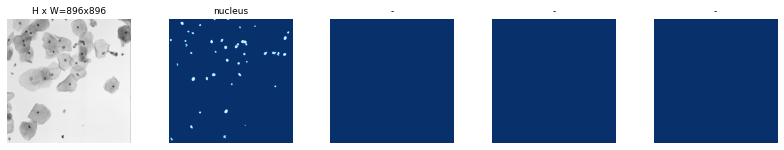

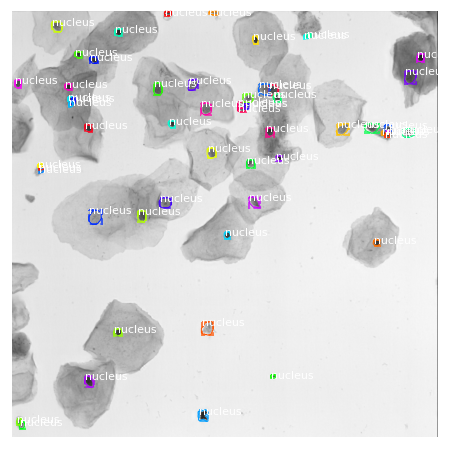

In [20]:
# Test on a random image
# image_id = random.choice(dataset_val.image_ids)
image_id = random.choice(dataset_train.image_ids) # should be traain dataset. hyl
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_train, inference_config, # should be train dataset. hyl
                           image_id, augmentation=None) #hyl 
                           # use_mini_mask=False) # use of mini mask is defined in config

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_top_masks(original_image, gt_mask, gt_class_id, dataset_train.class_names)
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (896, 896, 3)         min:    7.68878  max:  253.27041  float64
molded_images            shape: (1, 896, 896, 3)      min: -116.01122  max:  149.37040  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  896.00000  int64
anchors                  shape: (1, 200508, 4)        min:   -0.20226  max:    1.13075  float32


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


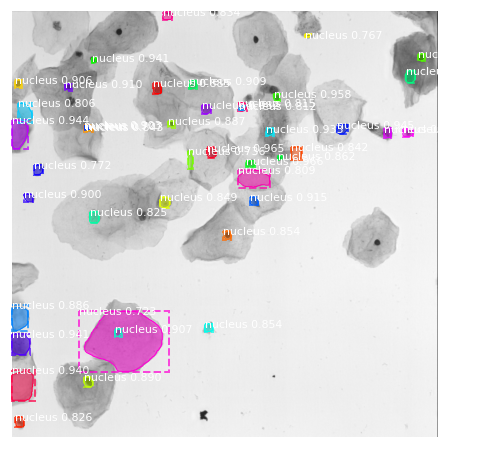

In [21]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [22]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 30 images. Increase for better accuracy.
# image_ids = np.random.choice(dataset_val.image_ids, 30)
image_ids = np.random.choice(dataset_val.image_ids, 10) # spf, 30 is too time-consuming.
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_train, inference_config, # should be train dataset. hyl
                               image_id) # hyl
                               #  use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.7340099633794963


In [23]:
# hyl
# process tif
from PIL import Image
import tifffile
import cv2

# %cd /content/drive/My Drive/Colab_Notebooks/datasets/nucleus/stage1_test/1/images/
%cd /content/drive/My Drive/Colab_Notebooks/datasets/nucleus/LF_image_x732_y1756/

# generate dataset
# tif_ob = Image.open("16_cell_stage.tif")
tif_ob = Image.open("LE_cal_arr_x732_y1756_reconstr.tif")
frames = tif_ob.n_frames
print(frames)


for frame in range(1,frames):
  tif_ob.seek(frame)
  new_path = "/content/drive/My Drive/Colab_Notebooks/datasets/nucleus/LF_image_x732_y1756/frame{}/images/".format(frame)
  if not os.path.exists(new_path):
    os.makedirs(new_path)

/content/drive/My Drive/Colab_Notebooks/datasets/nucleus/LF_image_x732_y1756
41


In [24]:
# hyl
# decompose tif, convert each layer to png and create folder for each frame
%cd /content/drive/My Drive/Colab_Notebooks/datasets/nucleus/LF_image_x732_y1756/

for layer in range(1,frames):
  tif = imread("LE_cal_arr_x732_y1756_reconstr.tif", key=layer)
  im = Image.fromarray(tif).convert("RGB") # convert each layer to png RGB image
  im.save("/content/drive/My Drive/Colab_Notebooks/datasets/nucleus/LF_image_x732_y1756/frame{}/images/frame{}.png".format(layer,layer))


/content/drive/My Drive/Colab_Notebooks/datasets/nucleus/LF_image_x732_y1756


Getting and resizing test images ... 


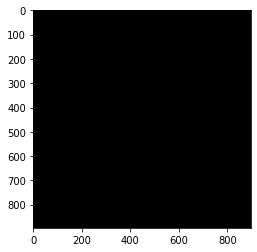

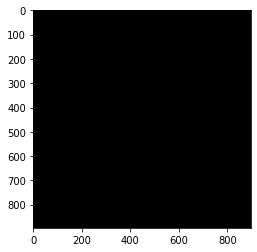

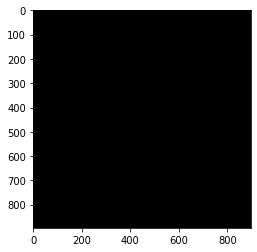

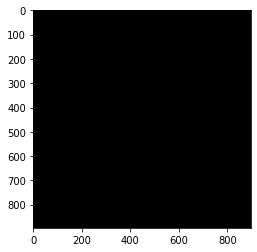

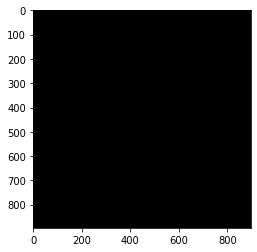

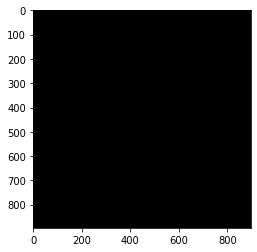

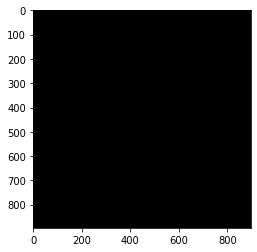

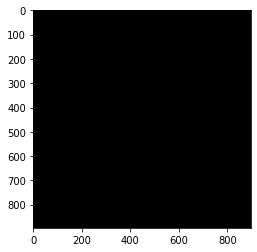

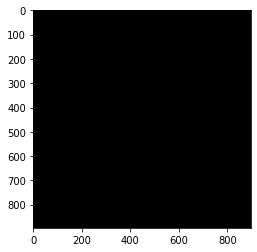

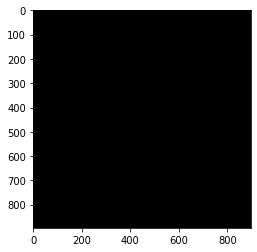

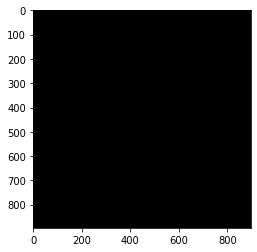

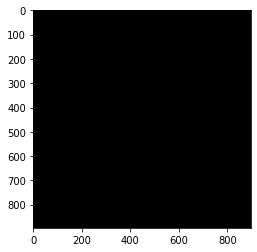

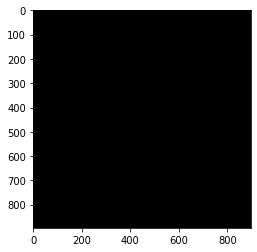

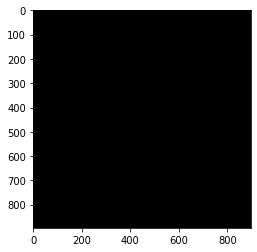

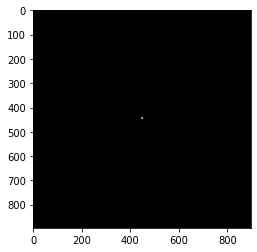

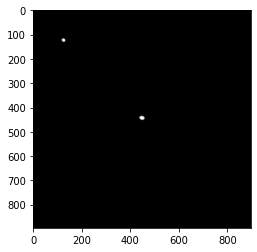

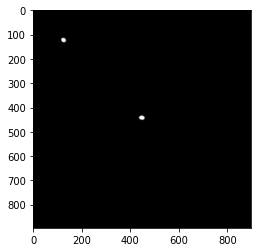

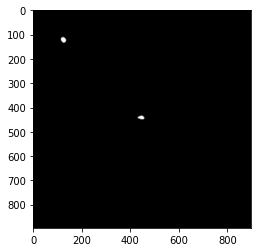

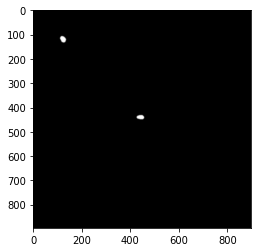

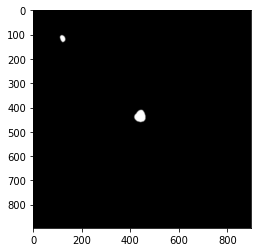

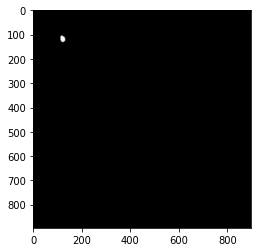

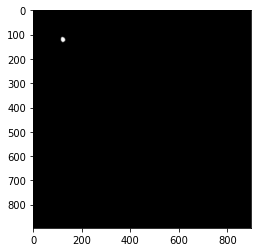

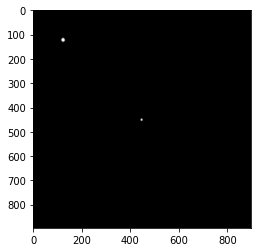

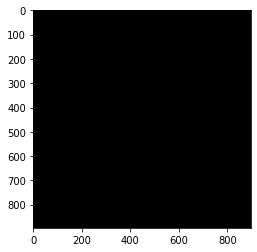

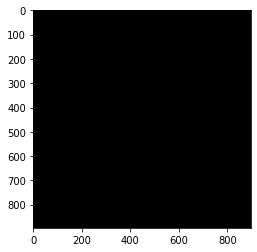

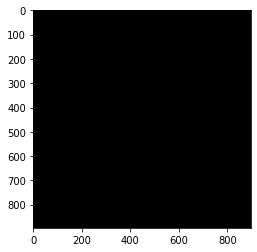

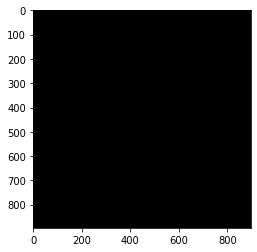

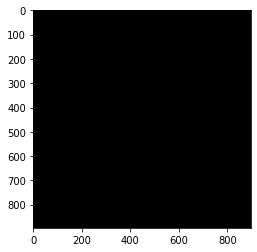

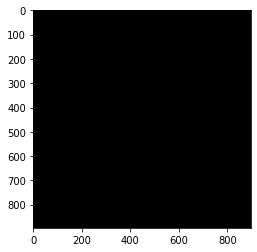

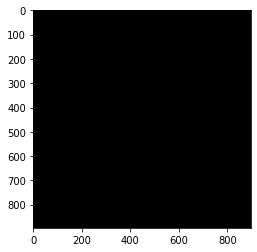

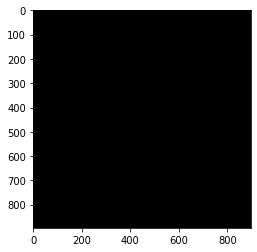

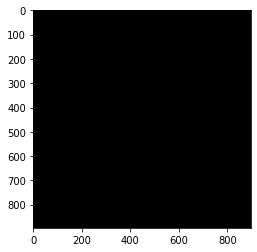

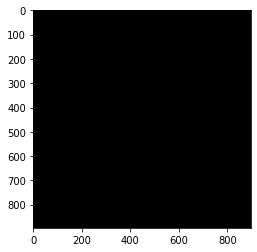

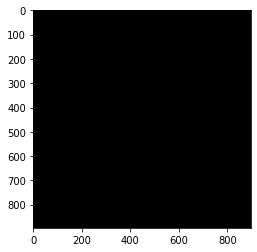

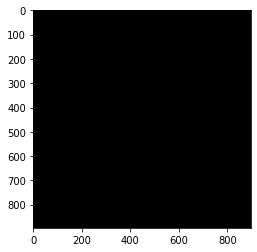

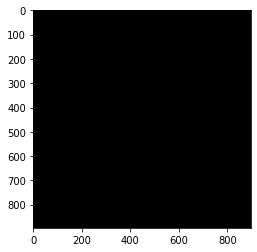

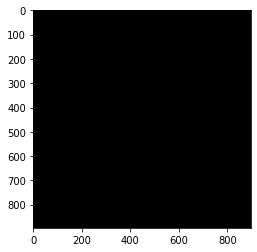

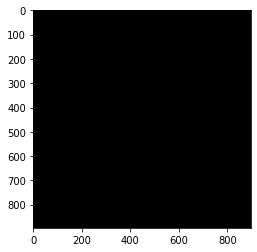

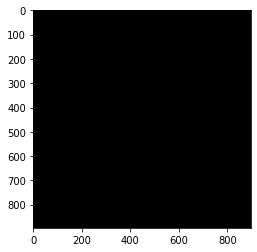

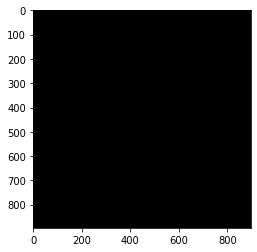

In [25]:
# hyl
# pre-processing each img and store it into the image stack for detection
import numpy as np
import cv2
from matplotlib import pyplot as plt # for test only
from skimage.filters import threshold_otsu # use the otsu auto-threshold algo

X_test = np.zeros((len(test_ids), config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], 3), dtype=np.uint8)
original_img = np.zeros((len(test_ids), config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], 3), dtype=np.uint8)
# IMAGE_SHAPE[0] and IMAGE_SHAPE[1] are both 896. the maximum dimension
# they can be set in config
sizes_test = []
_test_ids = []
TEST_PATH = "/content/drive/My Drive/Colab_Notebooks/datasets/nucleus/LF_image_x732_y1756/"

print('Getting and resizing test images ... ')
#sys.stdout.flush()
for n, id_ in enumerate(test_ids):
    _test_ids.append([id_])
    path = TEST_PATH + id_
    img = ori_img = imread(path + '/images/' + id_ + '.png')[:,:,:3]
    # resize the original image and store it
    ori_img = resize(ori_img, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
    original_img[n] = ori_img
    #denoise the image
    img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
    # threhold the image to make the background black (manual threshold)
    ret,img = cv2.threshold(img,170,255,cv2.THRESH_BINARY) 
    # gaussian blurring
    img = cv2.GaussianBlur(img,(7,7),0) 
    # Creating our sharpening filter
    filter = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]) 
    # Applying cv2.filter2D function on our Cybertruck image
    img[:,:,0]=cv2.filter2D(img[:,:,0],-1,filter)
    img[:,:,1]=cv2.filter2D(img[:,:,1],-1,filter)
    img[:,:,2]=cv2.filter2D(img[:,:,2],-1,filter)
    # #resize image
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
    #convert the imgae to RBG
    img = img.astype(np.uint8)
    # # # calculate number of zero pads that need to be added (no need for this anymore)
    # columns = len(img[0])
    # rows = len(img)
    # row_start_pos = int((config.IMAGE_SHAPE[0] - rows)/2)
    # row_end_pos = row_start_pos + rows
    # column_start_pos = int((config.IMAGE_SHAPE[1] - columns)/2)
    # column_end_pos = column_start_pos + columns
    # # create the 0 array for padding
    # pad_img = np.zeros((config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], 3))
    # pad_img[row_start_pos:row_end_pos, column_start_pos:column_end_pos] = img
    # print("frame{}".format(id_))
    plt.imshow(img) # for test only
    plt.show() # for test only
    X_test[n] = img
    # X_test[n] = pad_img

In [26]:
# hyl
# do a maximum/pixel average projection to every three images 
# pixel average projection is better than the maximum projection 
import statistics
mean_img = np.zeros((config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], 3), dtype=np.uint8)
averaged_length = int(len(test_ids)/5)
X_test_averaged = np.zeros((averaged_length, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], 3), dtype=np.uint8)
# max_img = np.zeros((config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], 3), dtype=np.uint8)
index = 0;
for n in range(0,len(X_test),5):
  print(n)
  # for i in range(20,config.IMAGE_SHAPE[0]-20):
  #   for j in range(20,config.IMAGE_SHAPE[1]-20):
  #     mean_img[i,j,0] = int(statistics.mean(X_test[n:n+2,i,j,0]))
  #     mean_img[i,j,1] = int(statistics.mean(X_test[n:n+2,i,j,1]))
  #     mean_img[i,j,2] = int(statistics.mean(X_test[n:n+2,i,j,2]))
      # max_img[i,j,0] = max(X_test[n:n+4,i,j,0])
      # max_img[i,j,1] = max(X_test[n:n+4,i,j,1])
      # max_img[i,j,2] = max(X_test[n:n+4,i,j,2])
  mean_img = np.add(X_test[n],X_test[n+1])
  mean_img = np.add(mean_img,X_test[n+2])
  mean_img = np.add(mean_img,X_test[n+3])
  mean_img = np.add(mean_img,X_test[n+4])
  mean_img = np.divide(mean_img,5)
  mean_img = np.rint(mean_img)
  # X_test[n]=max_img
  # X_test[n+1]=max_img
  # X_test[n+2]=max_img
  # X_test[n+3]=max_img
  # X_test[n+4]=max_img
  X_test_averaged[index] = mean_img
  index = index + 1


0
5
10
15
20
25
30
35


In [27]:
# process the ground truth, extract the target window from the wide-field
%cd /content/drive/My Drive/Colab_Notebooks/datasets/nucleus/wide_field

# set the value of layer to the frame number of the ground truth that is used for comparison
layer = 29

ground_tif = imread("wide_field.tif", key=layer)
ground_tif = ground_tif/100 # divide by 100 to reduce it to rbg scale
# ground_png = Image.fromarray(ground_tif).convert("RGB") # for test only

# set the coordinate of the target neurons in wide-field
x1 = 732
y1 = 1756
image_size = 512

# extract the target window (i.e. the ground truth)
ground_truth_window = ground_tif[(y1-int(image_size/2)):(y1+int(image_size/2)), (x1-int(image_size/2)):(x1+int(image_size/2))]
ground_truth_window_png = Image.fromarray(ground_truth_window).convert("RGB")
ground_truth_window_png.save("/content/drive/My Drive/Colab_Notebooks/datasets/nucleus/wide_field/x{}_y{}_gt.png".format(x1,y1))

whole_wide_field = Image.fromarray(ground_tif).convert("RGB")
whole_wide_field.save("/content/drive/My Drive/Colab_Notebooks/datasets/nucleus/wide_field/whole_wide_field_gt.png")
# ground_truth_window_png # for test only


/content/drive/My Drive/Colab_Notebooks/datasets/nucleus/wide_field


TiffPage 0: TiffFileError: invalid tag value offset
TiffPage 0: TiffFileError: invalid tag value offset
TiffPage 0: TiffFileError: invalid tag value offset
TiffPage 0: TiffFileError: invalid tag value offset


checking a test image with masks ...
Processing 1 images
image                    shape: (896, 896, 3)         min:    0.00000  max:   51.00000  uint8
molded_images            shape: (1, 896, 896, 3)      min: -123.70000  max:  -52.90000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  896.00000  int64
anchors                  shape: (1, 200508, 4)        min:   -0.20226  max:    1.13075  float32
[[414 420 463 461]
 [102 112 134 139]]
[1 1]
/content/drive/My Drive/Colab_Notebooks/datasets/nucleus/wide_field


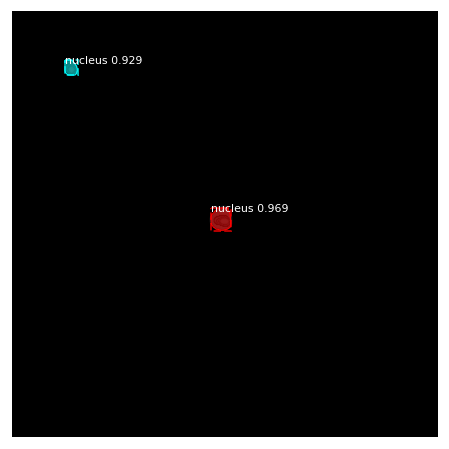

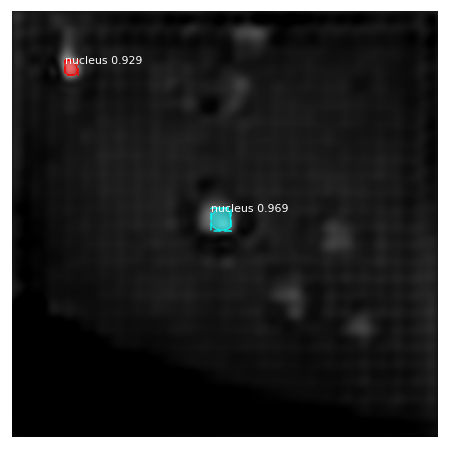

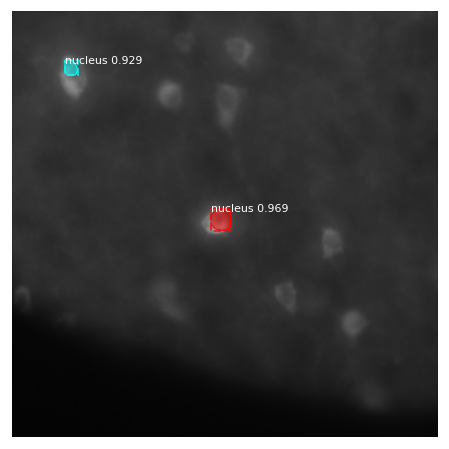

In [28]:
# hyl
# test on a single frame
print("checking a test image with masks ...")
results = model.detect([X_test_averaged[3]], verbose=1)

r = results[0]
# mask and rois on the processed image
visualize.display_instances(X_test_averaged[3], r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())
# mask and rois on the original unprocessed LF image
visualize.display_instances(original_img[20], r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

print(r['rois'])
print(r['class_ids'])


# compare the result with ground truth (wide-field)
%cd /content/drive/My Drive/Colab_Notebooks/datasets/nucleus/wide_field

ground_truth_window = imread("x{}_y{}_gt.png".format(x1,y1))
ground_truth_window = resize(ground_truth_window, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
visualize.display_instances(ground_truth_window, r['rois'], r['masks'], r['class_ids'],
                            dataset_val.class_names, r['scores'], ax=get_ax())

checking a test image with masks ...
Processing 1 images
image                    shape: (896, 896, 3)         min:    0.00000  max:    0.00000  uint8
molded_images            shape: (1, 896, 896, 3)      min: -123.70000  max: -103.90000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  896.00000  int64
anchors                  shape: (1, 200508, 4)        min:   -0.20226  max:    1.13075  float32

*** No instances to display *** 

Processing 1 images
image                    shape: (896, 896, 3)         min:    0.00000  max:   51.00000  uint8
molded_images            shape: (1, 896, 896, 3)      min: -123.70000  max:  -52.90000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  896.00000  int64
anchors                  shape: (1, 200508, 4)        min:   -0.20226  max:    1.13075  float32
Processing 1 images
image                    shape: (896, 896, 3)         min:    0.00000  max:   51.00000  uint8
molded_images 

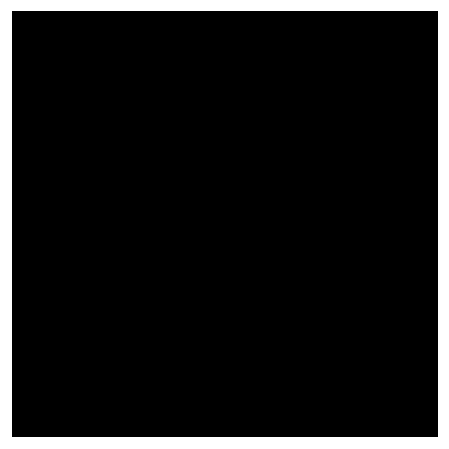

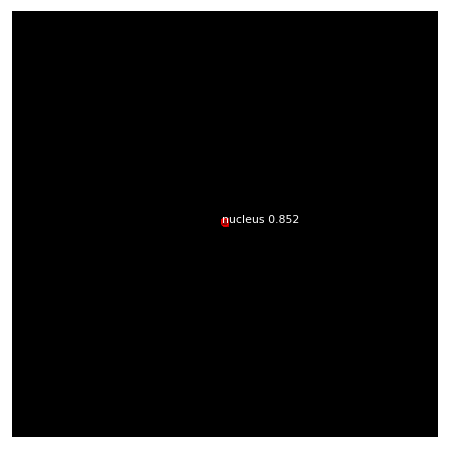

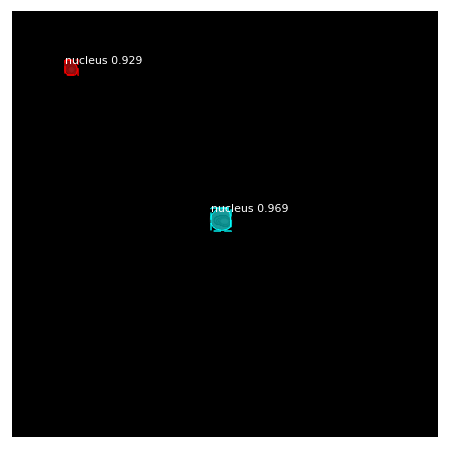

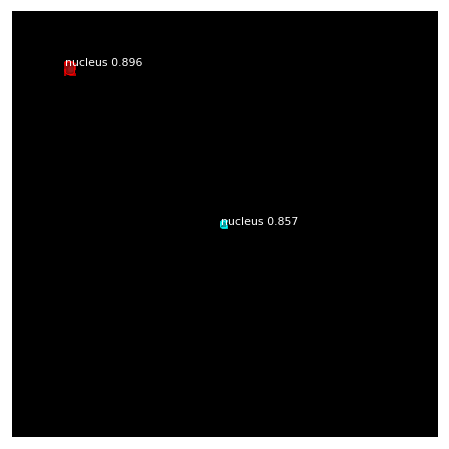

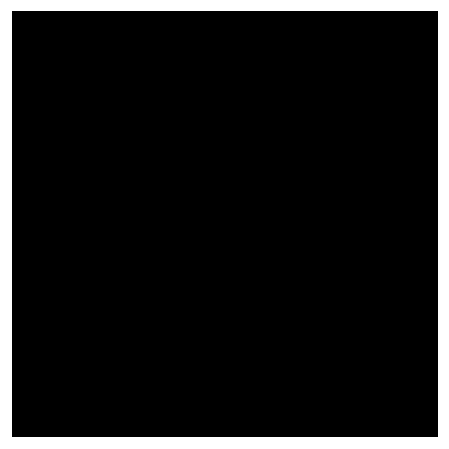

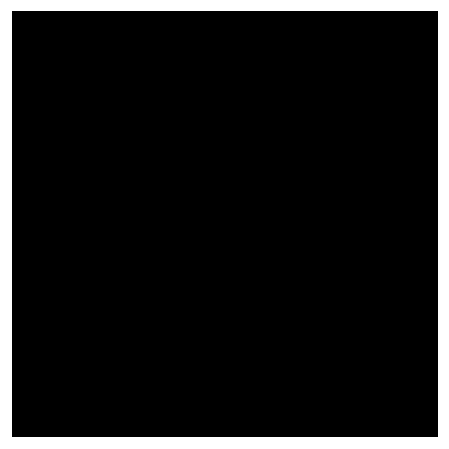

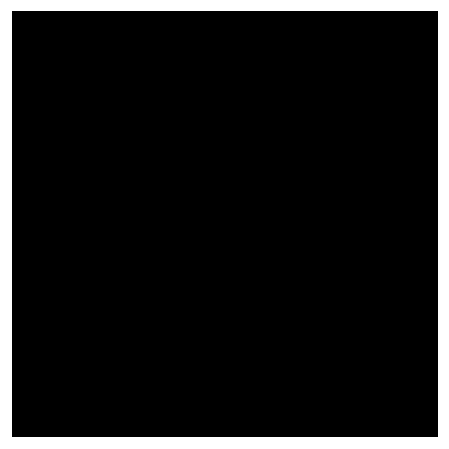

In [29]:
# hyl
# run the detection for every averaged frame of the file
# store every rois for actual position calculation
print("checking a test image with masks ...")
rois = {} # use of dictionaries to store the coordinates of the detected cell at each depth
for n in range(1,len(X_test_averaged)):
  results = model.detect([X_test_averaged[n]], verbose=1)
  r = results[0]
  visualize.display_instances(X_test_averaged[n], r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())
  # store every rois
  if (len(r['class_ids']) == 1):
    #rois.append(r['rois'][0])
    # store the x and y coordinate of the center of the roi
    x1 = r['rois'][0][0]
    y1 = r['rois'][0][1]
    x2 = r['rois'][0][2]
    y2 = r['rois'][0][3]
    rois["depth {}um-{}um".format(5*n,5*(n+1))] = [[int((x2+x1)/2), int((y2+y1)/2)]]
  elif (len(r['class_ids']) > 1) and (len(r['class_ids']) != 0):
    x1 = r['rois'][0][0]
    y1 = r['rois'][0][1]
    x2 = r['rois'][0][2]
    y2 = r['rois'][0][3]
    rois["depth {}um-{}um".format(5*n,5*(n+1))] = [[int((x2+x1)/2), int((y2+y1)/2)]]
    for i in range(1,len(r['class_ids'])):
      #rois.append(r['rois'][i]) 
      x1 = r['rois'][i][0]
      y1 = r['rois'][i][1]
      x2 = r['rois'][i][2]
      y2 = r['rois'][i][3]
      rois["depth {}um-{}um".format(5*n,5*(n+1))].append([int((x2+x1)/2), int((y2+y1)/2)])

In [30]:
# hyl
# print the coordinates and depths for the detected cells.
for x,y in rois.items():
  if (len(y) == 1):
    print("At {}, 1 cell is recognized, the coordinate is x:{} and y:{}.".format(x, y[0][0], y[0][1]))
  else:
    for i in range(len(y)):
      print("At {}, {} cells are recognized, the coordinate cell{} is x:{} and y:{}.".format(x, len(y), i+1, y[i][0], y[i][1]))

At depth 10um-15um, 1 cell is recognized, the coordinate is x:444 and y:449.
At depth 15um-20um, 2 cells are recognized, the coordinate cell1 is x:438 and y:440.
At depth 15um-20um, 2 cells are recognized, the coordinate cell2 is x:118 and y:125.
At depth 20um-25um, 2 cells are recognized, the coordinate cell1 is x:119 and y:122.
At depth 20um-25um, 2 cells are recognized, the coordinate cell2 is x:448 and y:446.


# Comparison with Other algorithms --- Otsu


In [ ]:
# hyl
# pre-processing each img and store it into the image stack for detection
import numpy as np
from skimage import color
import cv2
from matplotlib import pyplot as plt # for test only
from skimage.filters import threshold_otsu # use the otsu auto-threshold algo

X_test = np.zeros((len(test_ids), config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], 3), dtype=np.uint8)
original_img = np.zeros((len(test_ids), config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], 3), dtype=np.uint8)
# IMAGE_SHAPE[0] and IMAGE_SHAPE[1] are both 896. the maximum dimension
# they can be set in config
sizes_test = []
_test_ids = []

print('Getting and resizing test images ... ')
#sys.stdout.flush()
for n, id_ in enumerate(test_ids):
    _test_ids.append([id_])
    path = TEST_PATH + id_
    img = ori_img = imread(path + '/images/' + id_ + '.png')[:,:,:3]
    # resize the original image and store it
    ori_img = resize(ori_img, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
    original_img[n] = ori_img
    #denoise the image
    img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
    # threhold the image by otsu auto-thresholding
    # since otsu_threhold only apply to grayscale image, extract each channel first
    red = img[:,:,0]
    green = img[:,:,1]
    blue = img[:,:,2]
    # then apply threshold_otsu to each channel
    thresh_r = threshold_otsu(red)
    thresh_g = threshold_otsu(green)
    thresh_b = threshold_otsu(blue)
    red = red > thresh_r
    green = green > thresh_g
    blue = blue > thresh_b
    # finally combine the three channels back to rgb
    img = np.dstack((red, green, blue))
    # #resize image 
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
    # plt.imshow(img) # for test only
    # plt.show() # for test only
    X_test[n] = img
    

Getting and resizing test images ... 


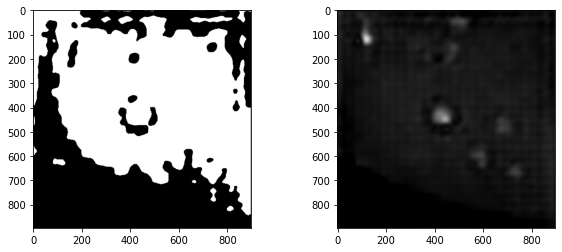

In [ ]:
# hyl

# compare the otsu auto-thresholding result with the original image
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(X_test[20]*255)
plt.subplot(122)
plt.imshow(original_img[20])

plt.show()


# Comparison with other algorithms --- Edge Detection

Getting and resizing test images ... 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


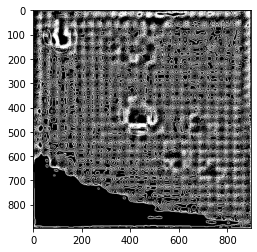

In [31]:
import numpy as np
from skimage import color
import cv2
from matplotlib import pyplot as plt # for test only
from scipy import ndimage
from PIL import Image, ImageChops

X_test = np.zeros((len(test_ids), config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], 3), dtype=np.uint8)
original_img = np.zeros((len(test_ids), config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], 3), dtype=np.uint8)
# IMAGE_SHAPE[0] and IMAGE_SHAPE[1] are both 896. the maximum dimension
# they can be set in config
sizes_test = []
_test_ids = []

print('Getting and resizing test images ... ')
#sys.stdout.flush()
for n, id_ in enumerate(test_ids):
    _test_ids.append([id_])
    path = TEST_PATH + id_
    img = ori_img = imread(path + '/images/' + id_ + '.png')[:,:,:3]
    # resize the original image and store it
    ori_img = resize(ori_img, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
    original_img[n] = ori_img
    # create the laplace operator for horizontal and vertical edge detection
    laplace = np.array([np.array([1, 1, 1]), np.array([1, -8, 1]), np.array([1, 1, 1])])
    img = color.rgb2gray(img)
    img = ndimage.convolve(img, laplace)
    img = color.gray2rgb(img)
    # #resize image 
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
    if n==20:
      plt.imshow(img*255) # for test only
      plt.show() # for test only
    X_test[n] = img
    # X_test[n] = pad_img
img = X_test[20]